# 📈 Portfolio Prediction Model - EDA & Training

This notebook demonstrates the end-to-end workflow of forecasting stock prices using both traditional ML (Random Forest) and deep learning (LSTM).

In [ ]:
import math
import pandas as pd
import numpy as np
import yfinance as yf

from datetime import datetime as dt, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-pastel")

In [4]:
import warnings

warnings.filterwarnings("ignore")

## 🧾 Load AAPL Stock Data

In [6]:
# load 10 years of data
end = dt.today()
start = end - timedelta(days=365 * 10)
df = yf.Ticker("AAPL").history(start=start, end=end)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-06-19 00:00:00-04:00,28.602806,28.627442,28.309410,28.354202,218867600,0.0,0.0
2015-06-22 00:00:00-04:00,28.553530,28.681191,28.461704,28.580406,136157200,0.0,0.0
2015-06-23 00:00:00-04:00,28.551296,28.580411,28.416915,28.450510,121075600,0.0,0.0
2015-06-24 00:00:00-04:00,28.490822,29.070897,28.470666,28.692392,221123600,0.0,0.0
2015-06-25 00:00:00-04:00,28.860360,28.936508,28.555765,28.555765,127752400,0.0,0.0


## Data Preprocessing

In [7]:
# Handle missing values
df.fillna(method="ffill", inplace=True)
df.dropna(inplace=True)

# Remove outliers
df = df[df["Close"] > 0]

# Drop columns we won't use
df.drop(columns=["Dividends", "Stock Splits", "Volume"], inplace=True)

In [8]:
df.head()

,Open,High,Low,Close
Date,,,,
2015-06-19 00:00:00-04:00,28.602806,28.627442,28.309410,28.354202
2015-06-22 00:00:00-04:00,28.553530,28.681191,28.461704,28.580406
2015-06-23 00:00:00-04:00,28.551296,28.580411,28.416915,28.450510
2015-06-24 00:00:00-04:00,28.490822,29.070897,28.470666,28.692392
2015-06-25 00:00:00-04:00,28.860360,28.936508,28.555765,28.555765


## Correlation Heatmap

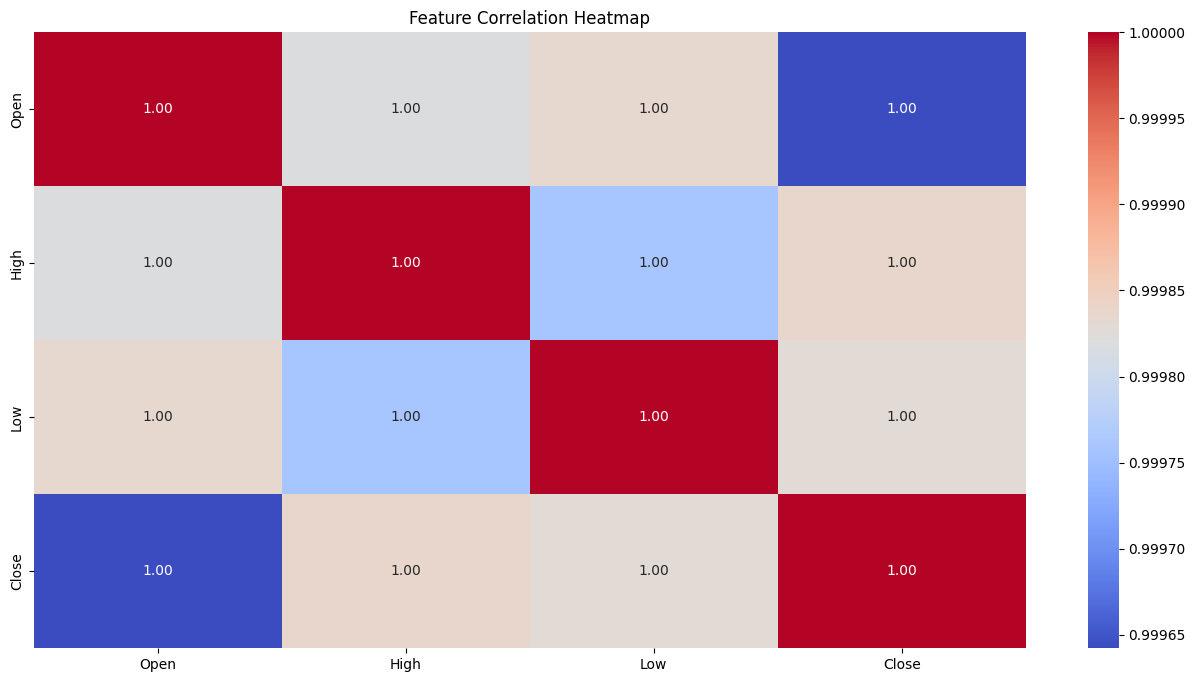

In [9]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

## Close Price History

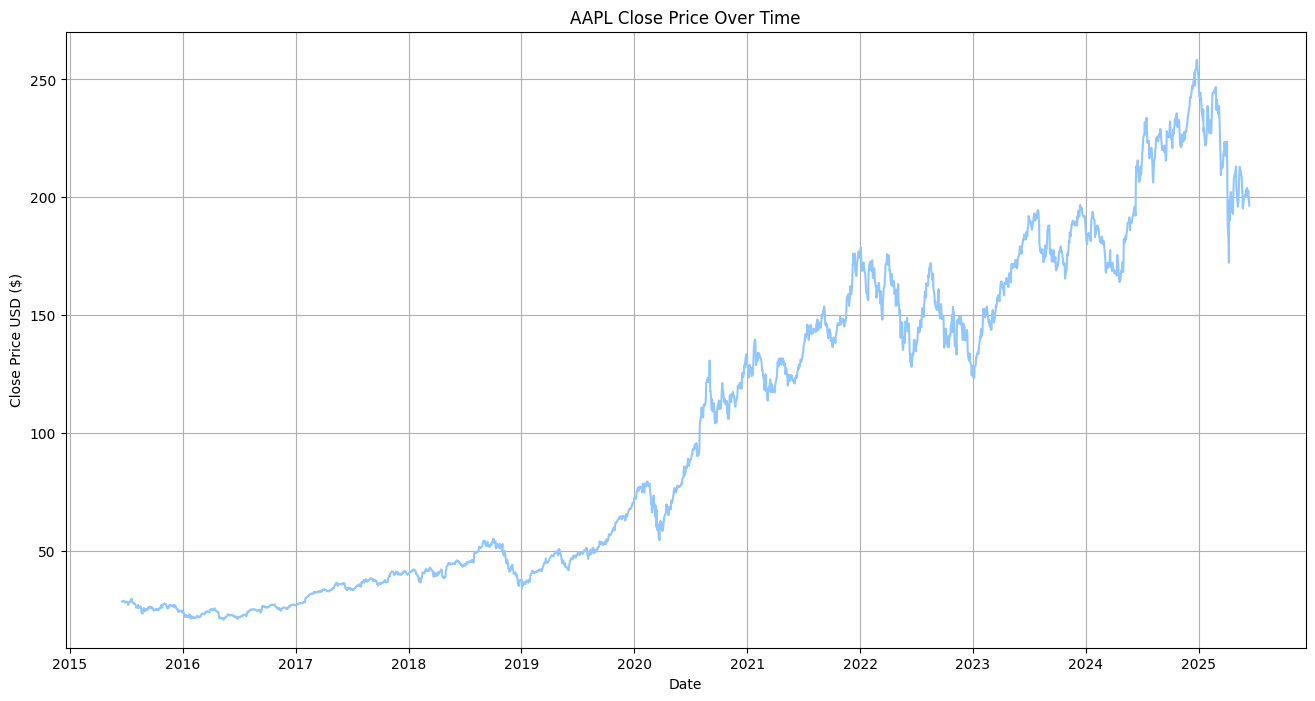

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(df["Close"])
plt.title("AAPL Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price USD ($)")
plt.grid(True)
plt.show()

## Scale Data and Prepare Train & Test Data

In [ ]:
data = df.filter(["Close"])
dataset = data.values

# getting 80% of data manually
"""
✅ Preserves temporal order, which is critical for time series.

✅ Ensures the model is never trained on future data.

✅ Commonly used for models like LSTM and even traditional ML when dealing with sequences.
"""
training_data_len = math.ceil(len(dataset) * 0.8)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [14]:
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len : i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [ ]:
# Create the training data set
train_data = scaled_data[:training_data_len, :]
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]

In [16]:
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

In [17]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1950, 502, 1950, 502)

## Predictions using Random Forest

#### Evaluation Metrics
#### MAE:
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

#### MSE:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

#### RMSE:
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
$$

In [ ]:
from sklearn.metrics import mean_squared_error

def train_rf_model(X_train, y_train, n_estimators=100, max_depth=None, random_state=42):
    """Train Random Forest Regressor."""
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    return model


def evaluate_rf_model(model, X_test, y_test):
    """Evaluate the trained model using RMSE."""
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"RMSE on Test Data: {rmse:.4f}")
    return predictions, rmse

In [48]:
# Train
rf_model = train_rf_model(X_train, y_train, n_estimators=100, max_depth=3)

# Evaluate
rf_predictions, rf_rmse = evaluate_rf_model(rf_model, X_test, y_test)
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

RMSE on Test Data: 0.1370


In [49]:
max_tree_depth = max(estimator.get_depth() for estimator in rf_model.estimators_)
print(f"Maximum depth among all trees: {max_tree_depth}")

Maximum depth among all trees: 23


### Prediction Visulization

In [45]:
def plot_preds(train, actual_plot, model_name):
    """
    Plot predictions comparing to training and actual data
    """
    plt.figure(figsize=(16, 8))

    plt.plot(
        train.index, train["Close"], label="Training Data", color="gray", linewidth=1.5
    )
    plt.plot(
        actual_plot.index,
        actual_plot["Close"],
        label="Actual Prices",
        color="dodgerblue",
        linewidth=2,
    )
    plt.plot(
        actual_plot.index,
        actual_plot["Predictions"],
        label="RF Predictions",
        color="orangered",
        linestyle="--",
        linewidth=2,
    )

    plt.title(f"{model_name} Stock Price Prediction", fontsize=20)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Close Price USD ($)", fontsize=14)
    plt.legend(loc="upper left", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [50]:
# Plot the data
train = data[:training_data_len]
actual = data[training_data_len:]

actual_plot = actual.copy()
actual_plot["Predictions"] = rf_predictions

model_name = "Random Forest"

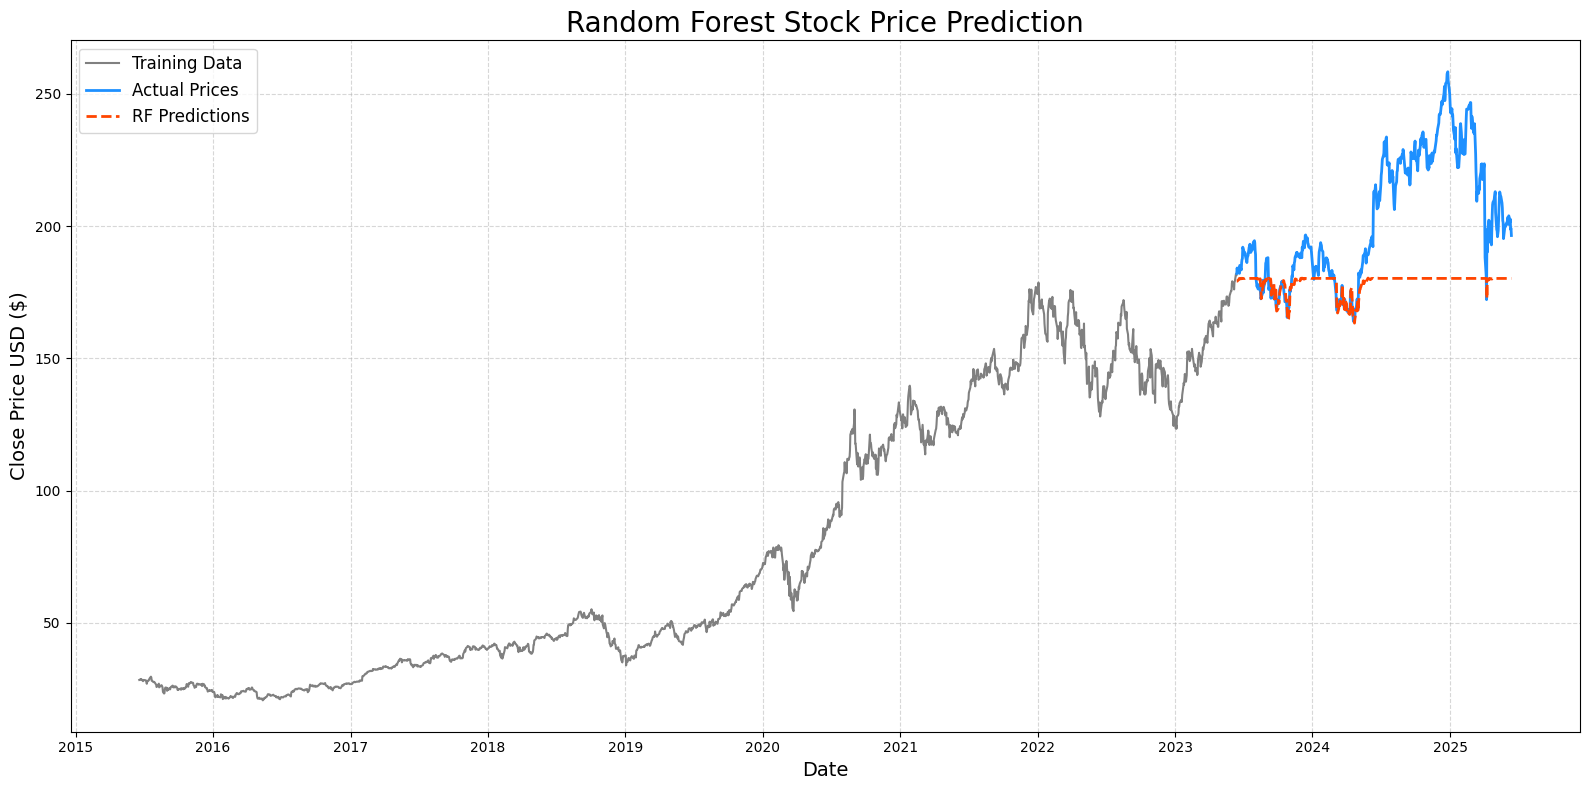

In [51]:
plot_preds(train, actual_plot, model_name)

In [53]:
# Show valid and predicted prices of Random Forest
actual_plot

,Close,Predictions
Date,,
2023-06-14 00:00:00-04:00,182.126495,179.156624
2023-06-15 00:00:00-04:00,184.166092,179.165492
2023-06-16 00:00:00-04:00,183.086899,179.305989
2023-06-20 00:00:00-04:00,183.175980,179.910690
2023-06-21 00:00:00-04:00,182.136414,180.247704
...,...,...
2025-06-09 00:00:00-04:00,201.449997,180.220406
2025-06-10 00:00:00-04:00,202.669998,180.220406
2025-06-11 00:00:00-04:00,198.779999,180.220406


## Long Short-Term Memory

`LSTM`, or `Long Short-Term Memory`, is a type of recurrent neural network (RNN) architecture particularly well-suited for processing and predicting sequential data. 

It excels at capturing long-term dependencies in sequences, making it useful in various applications like language modeling, speech recognition, and time series forecasting. 

## Data preparation

In [54]:
# Reshape the X_train & X_test data
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train_lstm.shape, X_test_lstm.shape

((1950, 60, 1), (502, 60, 1))

In [68]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = StockDataset(X_train_lstm, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [59]:
class LSTMModel(nn.Module):
    def __init__(self, in_features: int = 1, 
                 hidden_units: int = 50, 
                 out_features: int = 1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=hidden_units,
            num_layers=2,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_units, hidden_units // 2)
        self.fc2 = nn.Linear(hidden_units // 2, out_features)
        
        self.hidden_units = hidden_units

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_units).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_units).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

In [65]:
device = (
  "cuda"
  if torch.cuda.is_available()
  else
  "mps"
  if torch.backends.mps.is_available()
  else
  "cpu"
)

device

'mps'

In [ ]:
def train_lstm_model(
    model: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    loss_fn: nn.Module, 
    train_loader: DataLoader,
    epochs: int = 10, 
):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            outputs = model(X).squeeze()
            loss = loss_fn(outputs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(
            f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}"
        )

In [88]:
lstm_model = LSTMModel(hidden_units=100).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

epochs = 10

torch.manual_seed(42)
train_lstm_model(lstm_model, optimizer, loss_fn, train_loader, 10)


Epoch 1, Loss: 0.0221
Epoch 2, Loss: 0.0005
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002


In [89]:
from sklearn.metrics import mean_squared_error
import numpy as np

# After training, run evaluation
lstm_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        preds = lstm_model(X_batch).squeeze().cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Training RMSE: {rmse:.4f}")

Training RMSE: 0.0136


### Get predictions

In [101]:
test_dataset = StockDataset(X_test_lstm, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [115]:
lstm_model.eval()
lstm_predictions = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = lstm_model(X_batch).cpu().numpy()
        lstm_predictions.extend(preds if preds.ndim == 1 else preds.tolist())

In [116]:
# Plot the data
train = data[:training_data_len]
actual = data[training_data_len:]

actual_plot = actual.copy()
lstm_predictions = scaler.inverse_transform(lstm_predictions)
actual_plot["Predictions"] = lstm_predictions

model_name = "LSTM"

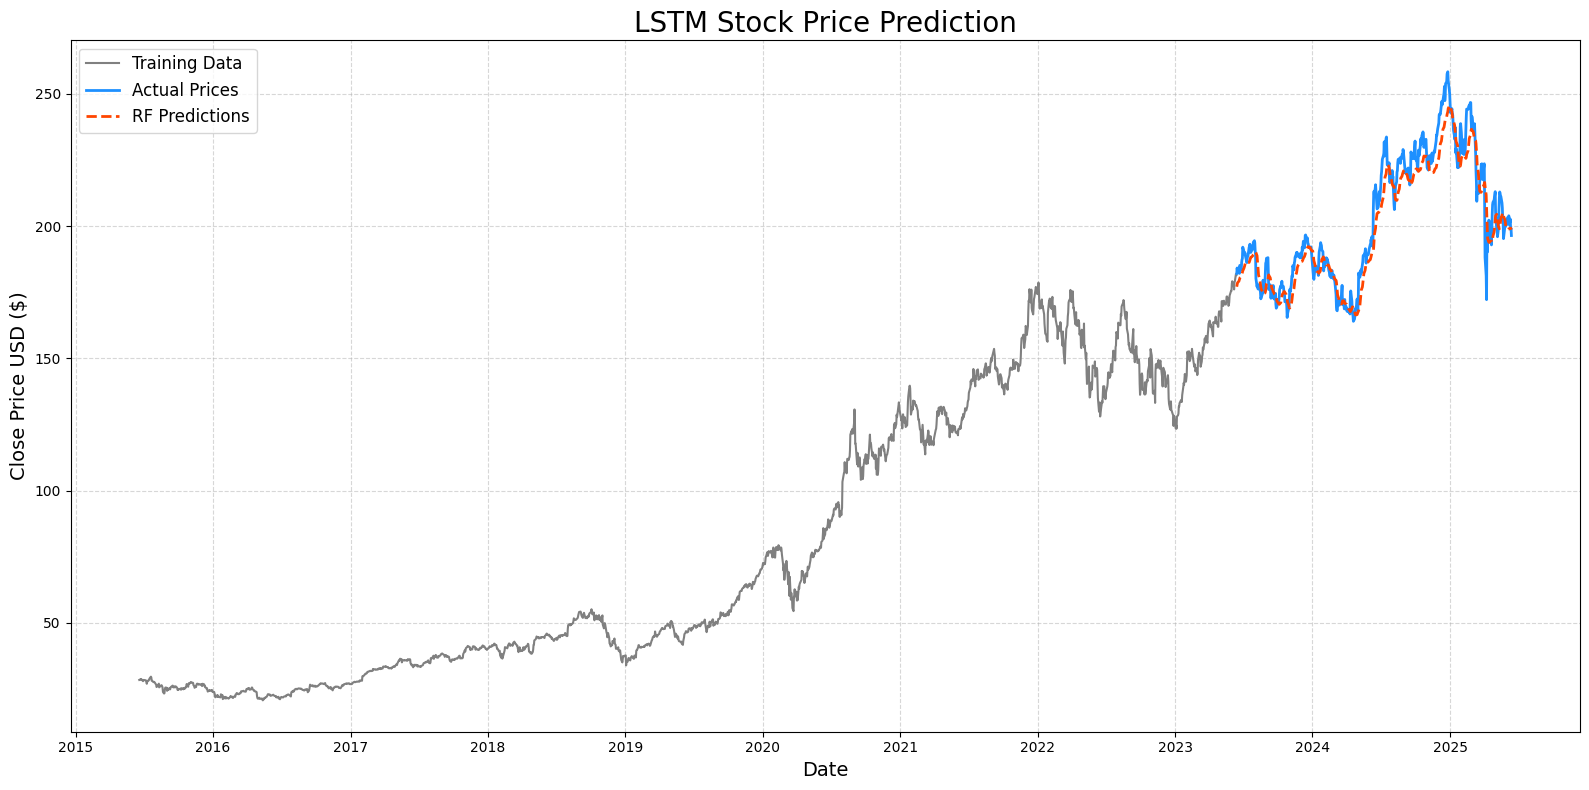

In [117]:
plot_preds(train, actual_plot, model_name)

In [119]:
# Show valid and predicted prices of LSTM
actual_plot

,Close,Predictions
Date,,
2023-06-14 00:00:00-04:00,182.126495,177.088362
2023-06-15 00:00:00-04:00,184.166092,177.760972
2023-06-16 00:00:00-04:00,183.086899,178.552604
2023-06-20 00:00:00-04:00,183.175980,179.231251
2023-06-21 00:00:00-04:00,182.136414,179.798316
...,...,...
2025-06-09 00:00:00-04:00,201.449997,199.106799
2025-06-10 00:00:00-04:00,202.669998,199.164687
2025-06-11 00:00:00-04:00,198.779999,199.261999


## Model Comparison

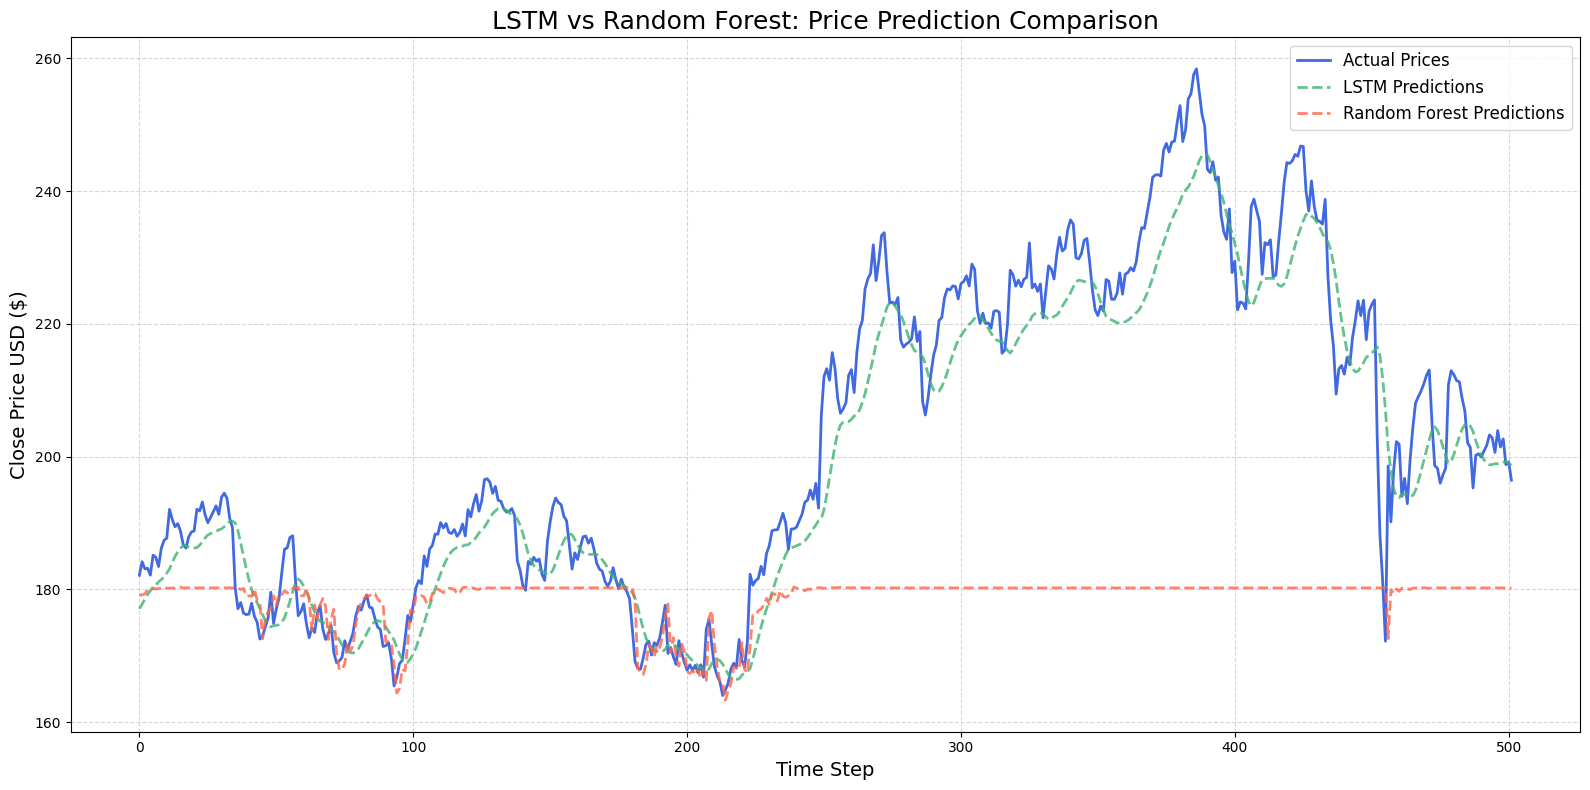

In [123]:
plt.figure(figsize=(16, 8))

y_test_inv = y_test.reshape((-1, 1))
y_test_inv = scaler.inverse_transform(y_test_inv)

# Plot actual prices
plt.plot(y_test_inv, label="Actual Prices", color="royalblue", linewidth=2)

# Plot LSTM predictions
plt.plot(
    lstm_predictions,
    label="LSTM Predictions",
    color="mediumseagreen",
    linestyle="--",
    linewidth=2,
    alpha=0.8,
)

# Plot Random Forest predictions
plt.plot(
    rf_predictions,
    label="Random Forest Predictions",
    color="tomato",
    linestyle="--",
    linewidth=2,
    alpha=0.8,
)

# Titles and labels
plt.title("LSTM vs Random Forest: Price Prediction Comparison", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Close Price USD ($)", fontsize=14)

# Additional styling
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

📌 Model Selection
Based on the performance comparison, the LSTM model demonstrates superior predictive accuracy compared to the Random Forest model. Its predictions align more closely with actual stock prices, particularly in capturing short-term fluctuations and trend patterns — which is essential in time series forecasting.

We selected Mean Absolute Error (MAE) as the primary evaluation metric. MAE performed best during validation, offering a more interpretable and stable measure of average prediction error. Its robustness to outliers makes it well-suited for volatile financial data where sudden spikes or drops can skew metrics like RMSE.

👉 As a result, the LSTM model is chosen as the final model for deployment and further experimentation.

## Save Model

In [126]:
import os

model_name = "portfolio-stock-predictor.pt"
model_dir = "../models"

os.makedirs(model_dir, exist_ok=True)

# Save model weights
torch.save(lstm_model.state_dict(), f"{model_dir}/{model_name}")

In [128]:
# Save the scaler
import joblib

model_scalar_name = "portfolio-stock-scaler.save"

joblib.dump(scaler, f"{model_dir}/{model_scalar_name}")

['../models/portfolio-stock-scaler.save']